# V. Weather Predictions: 'Classic' Machine Learning Models Vs Keras

There's no shortage of online tutorials on specific data science tasks. What's harder to find are tutorials that connect the dots for newcomers, and help them explore the next phase once they've build up some level of familiarity in an area, say, machine learning basics.

After spending a good part of 2019 learning the basics of machine learning, I was keen to start experimenting with some rudimentary deep learning. But there wasn't an obvious way to start. So I decided to pull together the materials I had found on the subject, and rustled up a series of notebooks that would hopefully help others who are looking to do the same.

In these notebooks, I use a mix of machine learning and deep learning techniques to try to predict the rain pattern in Singapore in December 2019 (validation set). The models will be trained on 37 years of weather data in Singapore, from Jan 01 1983 to the end of November in 2019. 

CAVEAT: While this dataset spans 37 years, it contains just under 13,500 rows of data. It is fair to ask whether you need deep learning for a dataset like this, and whether it necessarily produces better results.

Frankly, these questions don't matter much to me as a newcomer to data science. Massive real-world datasets are hard to come by, especially in Singapore. I much prefer to continue experimenting and learning new techniques, instead of waiting for the perfect dataset to drop on my lap.

# PART 1: 'CLASSIC' ML APPROACH USING LOGISTIC REGRESSION  AND XGB CLASSIFIER

In notebook 5.1, I'll focus on the 'classic' machine learning approach to predictive classification using pipelines and grid search to find the optimal parameters. 

To keep things simple, I'll design this as a binary classification problem, ie, predict whether a particular day is rainy (1) or dry (0).

I'll build and run a pipeline with two models - Logistic Regression and XGBoost. 

I chose these two models to illustrate another key consideration in machine learning - time/resource trade-off. Tuning some of the more complex models could take days and considerable computing resources, something which might not be viable for real-world projects.

In [1]:
import joblib 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from yellowbrick.classifier import ClassificationReport

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# 1. DATA PRE-PROCESSING

## 1.1 CREATE TARGET COLUMN 

In [2]:
# loading the dataset prepared in notebook 5.0

weather = pd.read_csv('../data/weather_model.csv')

In [3]:
# Creating a new target column
# To keep the project simple, I'll focus on predicting rainfall at a binary level - rain (1), or no rain (0)

weather['Rain_Or_Not'] = np.where(weather['Daily Rainfall Total (mm)'] > 0, 1, 0)

In [4]:
# 52.2% days with no rain, 47.8 rainy days
# The target values are slightly imbalanced in distribution, but not egregiously so
# I won't take additional steps to balance out the distribution, but feel free to consider options like SMOTE

weather['Rain_Or_Not'].value_counts()

0    7036
1    6447
Name: Rain_Or_Not, dtype: int64

In [5]:
weather.tail()

,Date,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Rain_Or_Not
13478,1983-01-05,1983,1,5,0.0,27.1,31.8,23.7,10.3,34.6,0
13479,1983-01-04,1983,1,4,0.0,27.3,30.8,25.0,12.6,42.1,0
13480,1983-01-03,1983,1,3,2.9,27.0,31.3,24.5,10.7,42.8,1
13481,1983-01-02,1983,1,2,0.4,26.8,30.6,24.8,9.4,43.2,1
13482,1983-01-01,1983,1,1,0.3,26.5,28.7,25.1,5.5,29.9,1


### NOTE: 
I've left the outliers *in* in this dataset, so as to give the models the maximum amount of information possible. In dealing with actual work-place projects, there should be a serious discussion about how many outliers to remove, and the trade-offs involved.

## 1.2 GETTING DATASET READY FOR COLUMN TRANSFORMER

Scikit Learn's pipeline feature is extremely handy for streamlining the pre-processing steps. In this project, we only have numeric features. But you can incorporate categorical features easily for your own project/dataset.

In [6]:
numeric_features = [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
]

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)

In [7]:
X = weather[
    [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
    ]
]

y = weather["Rain_Or_Not"]


## 1.3 TRAIN-TEST-SPLIT TRAINING DATA

In [8]:
# Use sklearn's train-test split, with stratify option, 
# to maintain an equitable split given the slightly imbalanced nature of the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [9]:
print(X_train.shape)
print(X_test.shape)

(10786, 5)
(2697, 5)


In [10]:
print(y_train.shape)
print(y_test.shape)

(10786,)
(2697,)


# 2. DUMMY BASELINE

A baseline model helps us gauge what's the minimum level of accuracy the model must achieve in order to be acceptable. In this case, it is about 0.5, which makes sense, ie, there's an equal chance a random guess would be accurate in telling us whether it would rain or not in Singapore.

In [11]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [12]:
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.5098257322951427


# 3. PIPELINE CONSTRUCTION + GRID SEARCH

You can fit as many competing models in this pipeline as you wish. It is common for up to a dozen or more models to be tested in the exploration phase.

I picked LogReg and XGB to illustrate the trade-off in time and resources involved in the grid search process. It took just seconds to find the best parameters for LogReg model. But it took a 6-core Mac Mini (2018) about 7 hours to do so for the XGB Classifier. You can expect a longer run time on laptops.

In the interests of time, I also held back on the number of hyperparameters to tune for the XGB Classifier. You can add roughly 10 more hyperparamters to the ones I've used below for the XGB Classifier. 

This would exponentially increase the amount of time required for the grid search. An alternative is to use RandomizedSearchCV instead of GridSearchCV. I've found RandomizedSearchCV to give rather satisfactory results from other projects.

Last note on this: Read the documentation for the models for the full set of parameters to tune. 

In [15]:
models = {
    "LogReg": (
        Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "clf",
                    LogisticRegression(
                        penalty="l2",
                        class_weight="balanced",
                        random_state=42,
                        verbose=1,
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
        {
            "clf__penalty": ["l2"],
            "clf__C": np.logspace(1, 5, 10),
            "clf__solver": ["liblinear", "newton-cg", "sag", "saga", "lbfgs"],
            "clf__max_iter": [100, 500, 1000, 1500],
        },
    ),
    "XGB": (
        Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "clf",
                    XGBClassifier(
                        base_score=0.5,
                        objective="binary:logistic",
                        reg_lambda=0.1,
                        n_estimators=1000,
                        max_delta_step=0,
                        scale_pos_weight=1,
                        subsample=0.5,
                        random_state=42,
                        n_jobs=-1,
                        verbosity=1,
                    ),
                ),
            ]
        ),
        {
            "clf__gamma": [i / 10.0 for i in range(1, 10)],
            "clf__reg_alpha": [1e-5, 1e-2, 0.1, 1, 10],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__min_child_weight": [i for i in range(2, 10)],
            "clf__max_depth": [10, 15, 20]
        },
    ),
}


In [16]:
# Due to the lengthy grid search process, it makes sense to save the models using joblib

for name, (model, parameters) in models.items():
    print("----- {} -----".format(name))

    gs = GridSearchCV(
        model,
        parameters,
        cv=5,
        n_jobs=-1,
        scoring="roc_auc",
        verbose=1,
        return_train_score=True,
    )

    gs.fit(X_train, y_train)
    print("Best Parameters:", gs.best_params_)
    print("")
    print("Best Score:", gs.best_score_)

    joblib.dump(gs.best_estimator_, f"{name}.pkl", compress=1)
    joblib.dump(gs.cv_results_, f"{name}_results.pkl", compress=1)

    y_pred = gs.predict(X_test)

    print("")
    print("Precision Score :", precision_score(y_test, y_pred))
    print("Recall Score:", recall_score(y_test, y_pred))
    print("f1 Score:", f1_score(y_test, y_pred))
    print("")


----- LogReg3 -----
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


convergence after 26 epochs took 0 seconds
Best Parameters: {'clf__C': 599.4842503189409, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'sag'}

Best Score: 0.7986293190987257

Precision Score : 0.7251732101616628
Recall Score: 0.7302325581395349
f1 Score: 0.7276940903823872

----- XGB3 -----
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 106.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 131.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 159.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 188.4min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 222.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 256.8min
/Users/chinhonchua/opt/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarn

Best Parameters: {'clf__gamma': 0.9, 'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__min_child_weight': 9, 'clf__reg_alpha': 10}

Best Score: 0.8203732932417501

Precision Score : 0.7595762021189894
Recall Score: 0.7224806201550388
f1 Score: 0.740564163686929



# 4. USING OPTIMISED XGB MODEL TO PREDICT RAIN PATTERN IN DEC 2019

The XGB Classifier scored better, so I'll move ahead with it. But if I'm in a time crunch, I'll clearly opt for the LogReg model which didn't perform too shabbily either. Is the 0.02 performance bump worth an additional 7 hours of processing time? That'll depend on the industry you are in, or the nature of the project.

In this case, predicting rain/no-rain patterns, one might argue that the performance gap between the 2 models might not make that big of a difference. Let's see:

In [13]:
# load up the optimised XGB model

XGB = joblib.load("XGB.pkl")

In [14]:
# Showing the finalised model the full training data-set, ahead of testing it on unseen data

XGB.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Mean Temperature (°C)',
                                                   'Maximum Temperature (°C)',
                                  

## 4.1 LOAD VALIDATION DATA SET

In [15]:
validate = pd.read_csv('../data/weather_dec2019.csv')

In [16]:
validate['Rain_Or_Not'] = np.where(validate['Daily Rainfall Total (mm)'] > 0, 1, 0)

In [17]:
X_validate = validate[
    [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
    ]
]

y_validate = validate["Rain_Or_Not"]

In [18]:
# There were 14 rainy days in Dec 2019

y_validate.value_counts()

0    17
1    14
Name: Rain_Or_Not, dtype: int64

## 4.2 GENERATE AND ASSESS PREDICTIONS BY XGB MODEL 

In [19]:
pred = XGB.predict(X_validate)

In [20]:
print("Accuracy Score:", accuracy_score(y_validate, pred))
print("Precision Score :", precision_score(y_validate, pred))
print("Recall Score:", recall_score(y_validate, pred))
print("f1 Score:", f1_score(y_validate, pred))

Accuracy Score: 0.8064516129032258
Precision Score : 0.8333333333333334
Recall Score: 0.7142857142857143
f1 Score: 0.7692307692307692


In [21]:
cm = confusion_matrix(y_validate, pred)
cm

array([[15,  2],
       [ 4, 10]])

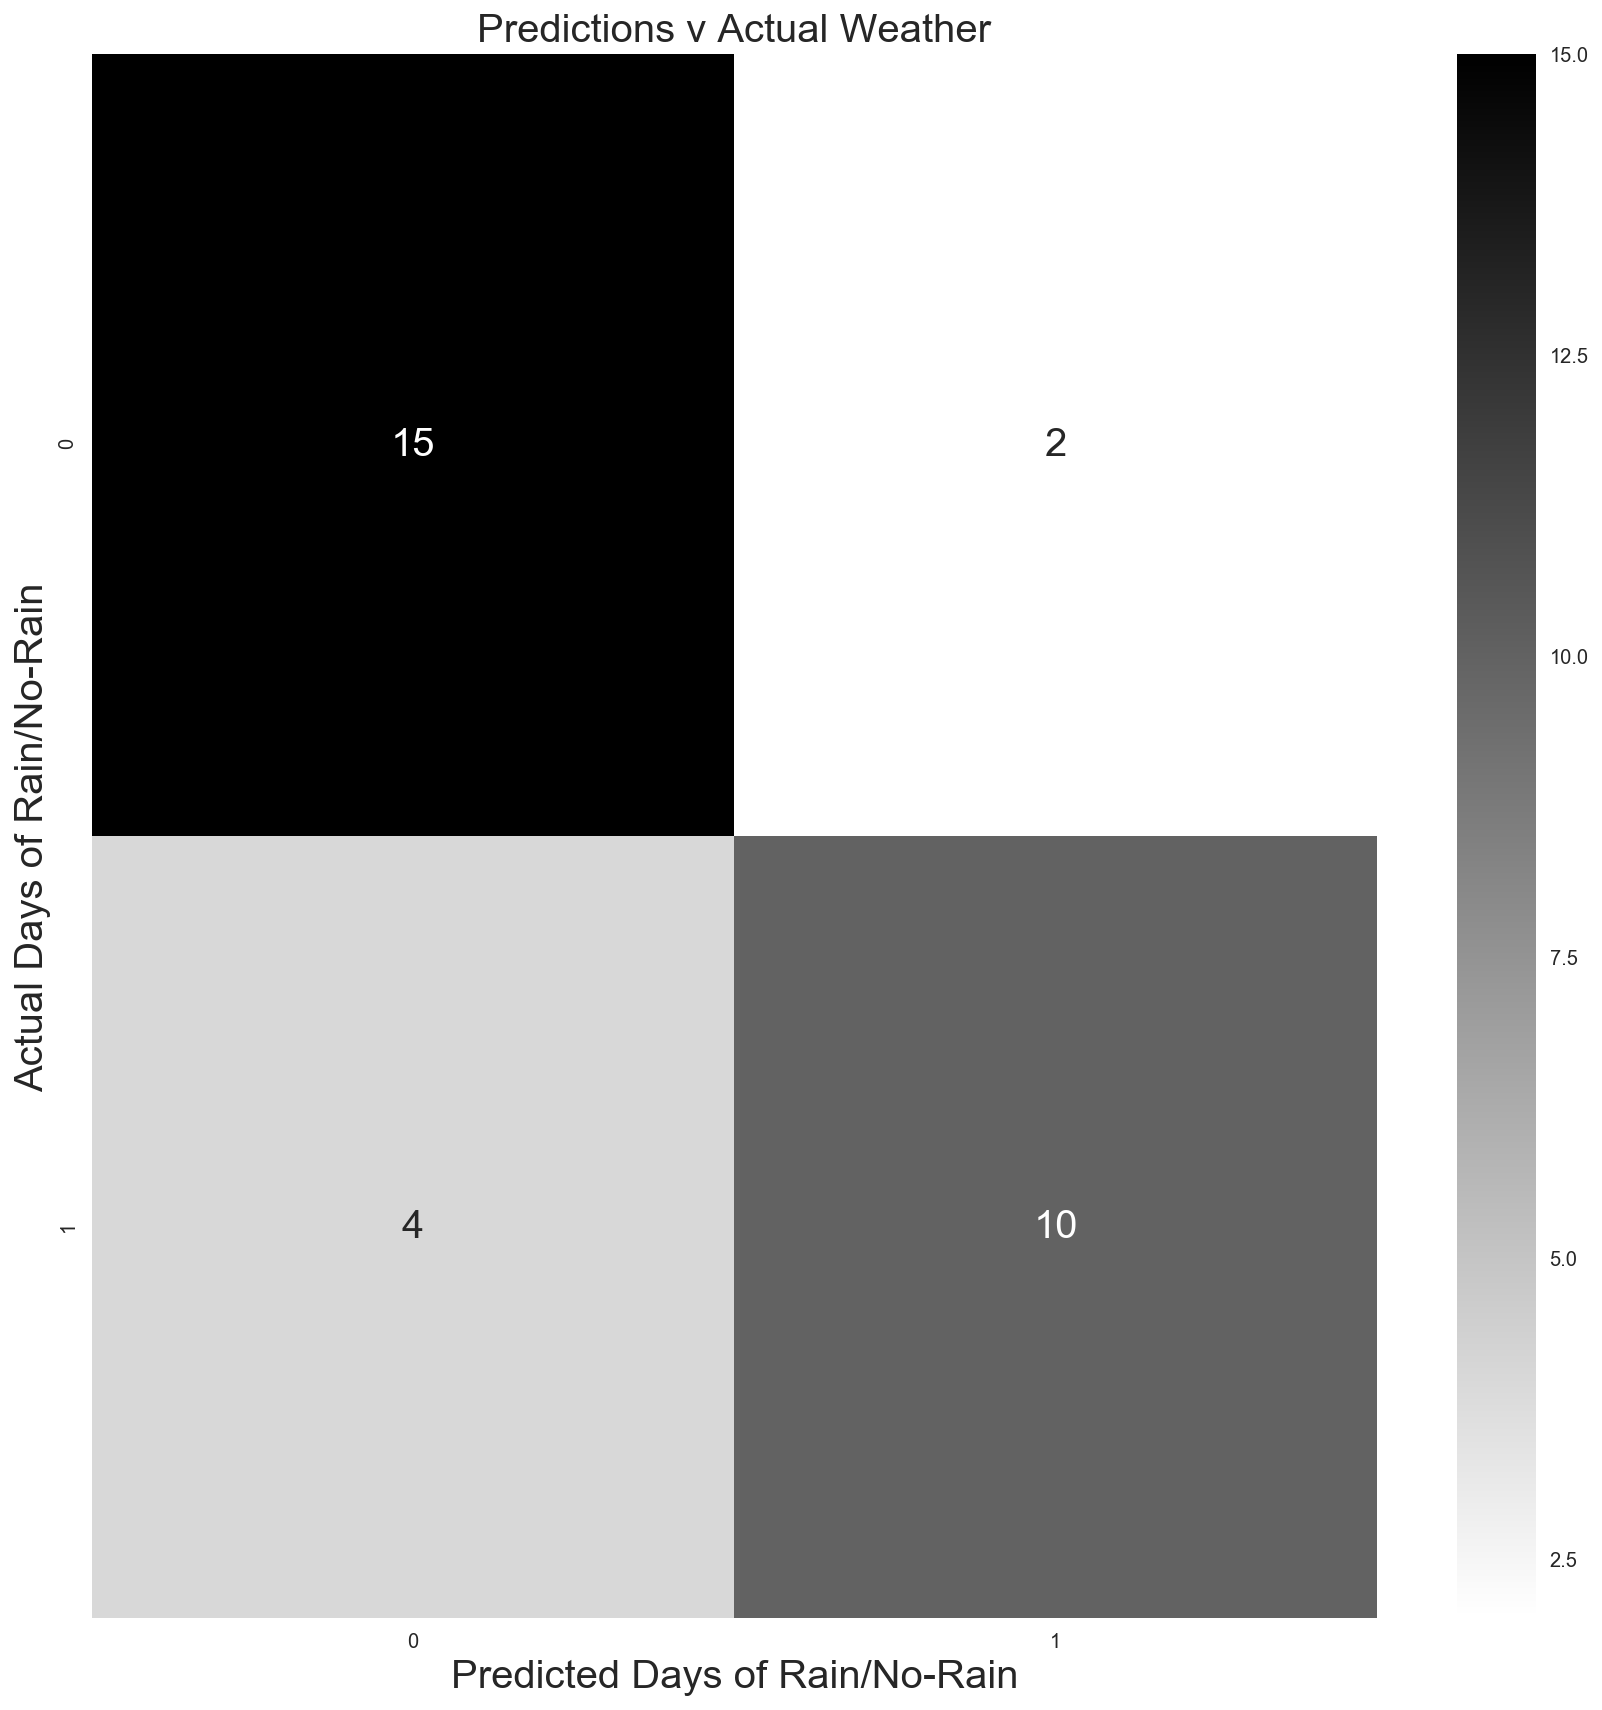

In [22]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="gist_gray_r", annot_kws={"size": 20})
plt.title("Predictions v Actual Weather", fontsize=20)
plt.ylabel("Actual Days of Rain/No-Rain", fontsize=20)
plt.xlabel("Predicted Days of Rain/No-Rain", fontsize=20)
plt.tight_layout()

## RESULTS:
Not too shabby. The XGB model correctly classified 25 rainy/dry days out of 31, giving it an accuracy score of 0.8.

The model wrongly predicted that it would rain on 2 days, when they were in fact sunny (false positives). It also wrongly predicted 4 sunny days when it in fact rained on those days (false negatives).

The XGB model is weakest in terms of its recall score, in this case meaning its ability to correctly identify rainy days as such (10 out of 14).

The chart below gives us an easier way to see how the model performed with its predictions:

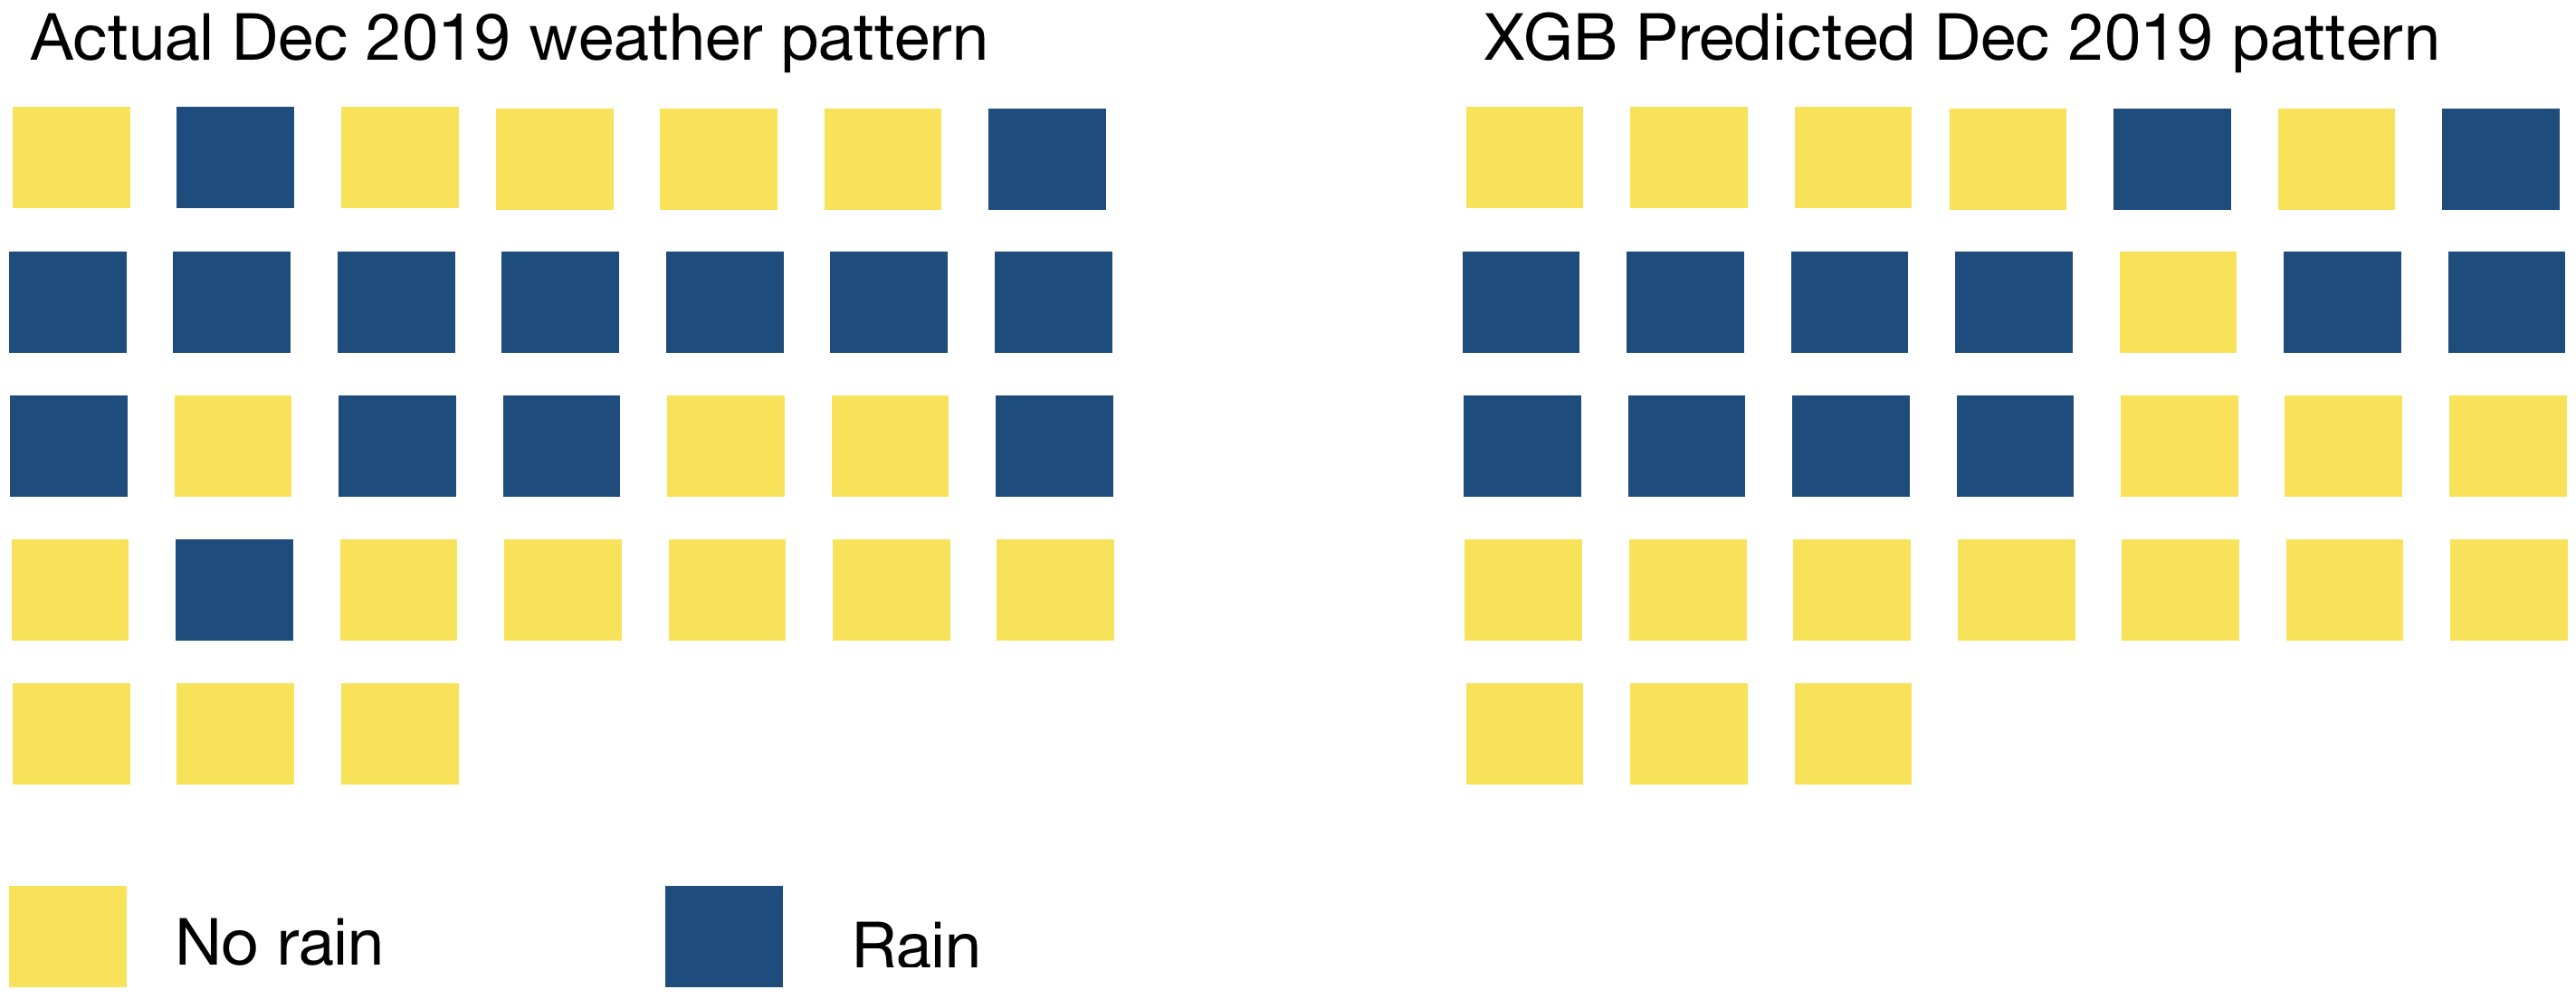

Next, let's see whether a deep learning model using the Keras Classifier can do better.